# SES Example: London Rainfall

In [1]:
rain.data<-scan("http://robjhyndman.com/tsdldata/hurst/precip1.dat", skip=1)
rain.ts<-ts(rain.data, start=c(1813))

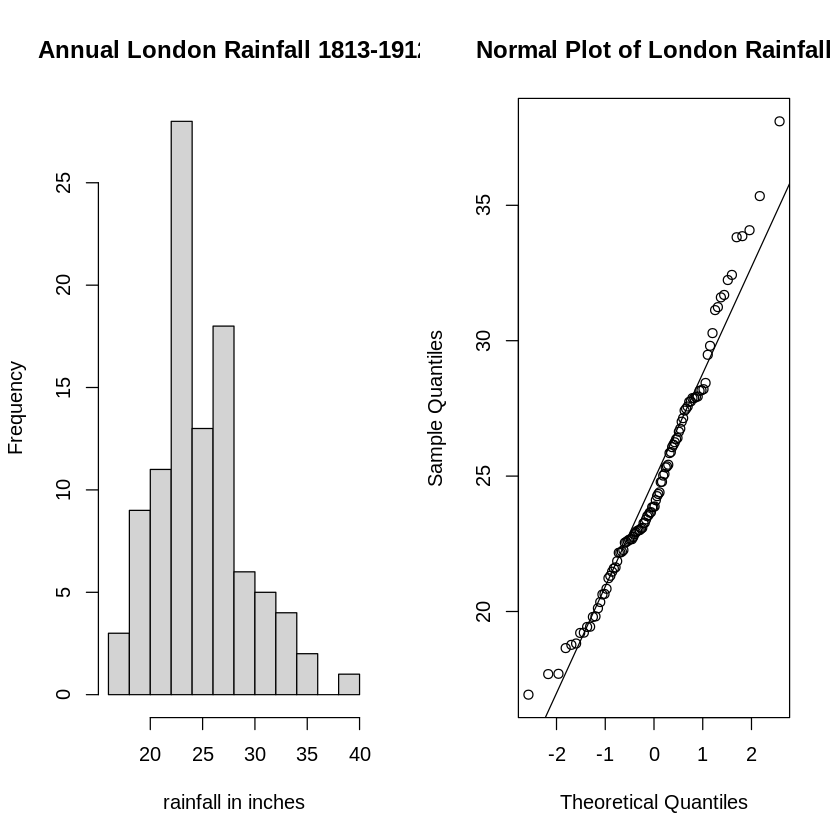

In [2]:
par(mfrow=c(1,2))

hist(rain.data, main='Annual London Rainfall 1813-1912', xlab='rainfall in inches')
qqnorm(rain.data, main='Normal Plot of London Rainfall')
qqline(rain.data)

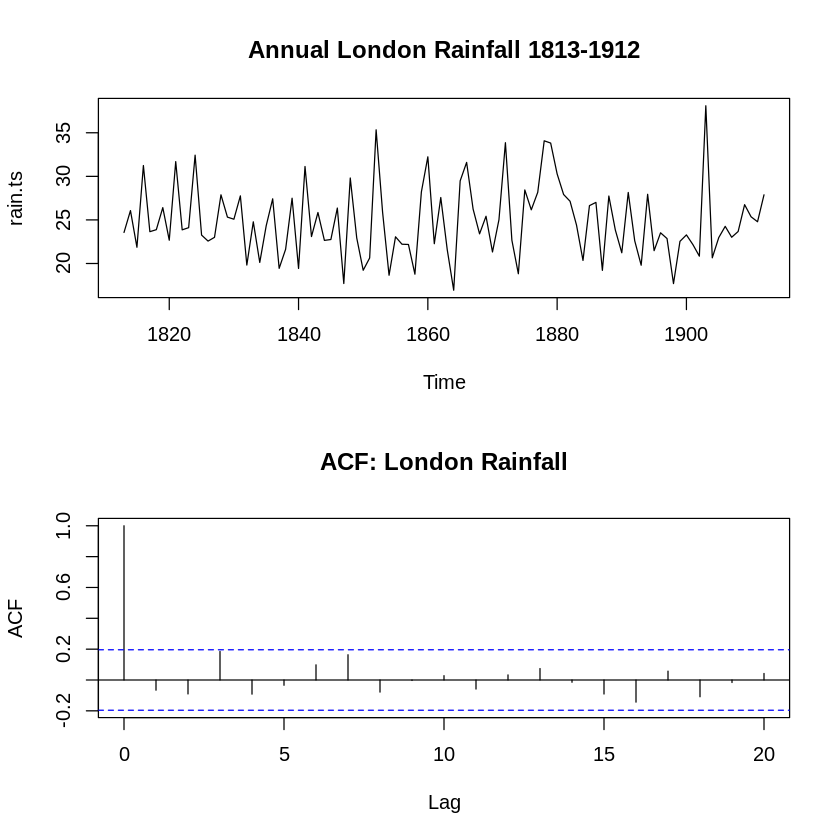

In [3]:
par(mfrow=c(2,1))

plot(rain.ts, main='Annual London Rainfall 1813-1912')
acf(rain.ts, main='ACF: London Rainfall')

=> systametic trend가 없는 그저 noise로 보임

In [8]:
install.packages('forecast')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘Rcpp’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’




In [9]:
require(forecast)
auto.arima(rain.ts) 

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Series: rain.ts 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
         mean
      24.8239
s.e.   0.4193

sigma^2 = 17.76:  log likelihood = -285.25
AIC=574.49   AICc=574.61   BIC=579.7

=> 모델도 역시 ARIMA(0,0,0) 반환. random walk

# 1. Simple Exponential Smoothing 
$x_{n+h}^n$ : $n=$ time for which you actually have data ;  $n+h=$ time for which you'd like a forecast <br>
- 예측에 level 하나만 고려

- naive method
$$x_{n+1}^n=x_n$$

- seasonal naive method
$$x_{n+1}^n=x_{n+1-S}$$

- average method
$$x_{n+1}^n=\frac{\sum_{i=1}^n x_i}{n}$$

- Simple Exponential Smooting
  - 직후의 값을 예측할 때 직전의 값과 직접 값의 예측값에 가중치를 곱해 도출
$$x_2^1=x_1$$
$$x_3^2=\alpha x_2 + (1-\alpha) x_2^1$$
$$x_4^3=\alpha x_3 + (1-\alpha) x_3^2$$

## 코드 

In [10]:
alpha=0.2  # alpha 증가시키면 더욱 빠르게 감소
forecast.values=NULL  # 예측값 저장할 변수

n=length(rain.data)

# naive first forecast
forecast.values[1]=rain.data[1]

In [11]:
# 예측값 생성을 위한 반복문
# 1913 예측

for(i in 1:n) {
  forecast.values[i+1]=alpha*rain.data[i]+(1-alpha)*forecast.values[i]
}

paste('forecast for time', n+1, '=', forecast.values[n+1])

[1] "forecast for time 101 = 25.3094062064236"

In [12]:
HoltWinters(rain.ts, beta=FALSE, gamma=FALSE) # alpha=levels; beta=trend; gamma=seasonality

Holt-Winters exponential smoothing without trend and without seasonal component.

Call:
HoltWinters(x = rain.ts, beta = FALSE, gamma = FALSE)

Smoothing parameters:
 alpha: 0.02412151
 beta : FALSE
 gamma: FALSE

Coefficients:
      [,1]
a 24.67819

In [13]:
# HoltWinters()에서 찾은 최적 알파값으로 예측치 다시 도출

alpha=0.02412151
forecast.values=NULL  # 예측값 저장할 변수

n=length(rain.data)

# naive first forecast
forecast.values[1]=rain.data[1]

# 예측값 생성을 위한 반복문
# 1913 예측
for(i in 1:n) {
  forecast.values[i+1]=alpha*rain.data[i]+(1-alpha)*forecast.values[i]
}

paste('forecast for time', n+1, '=', forecast.values[n+1])

[1] "forecast for time 101 = 24.678193785589"

# 2. Double Exponential Smooting
- 예측에 level 뿐만 아니라 trend도 고려
$$forecast\ = \ level+trend$$
$$\hat{x}_{n+1}=level_n + 1 \cdot trend_n$$
where, <br>
$level_n=\alpha \cdot \text{new information} + (1-\alpha)(\text{old level}+\text{amount of trend})$
$level_n= \alpha x_n + (1-\alpha)(level_{n-1}+trend_{n-1})$
$trend_n=\beta \cdot \text{new trend} + (1-\beta)\cdot \text{old trend}$
$trend_n= \beta \cdot (level_n - level_{n-1}) +(1-\beta)trend_{n-1}$

In [17]:
m=HoltWinters(rain.ts, gamma=FALSE)
m

Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = rain.ts, gamma = FALSE)

Smoothing parameters:
 alpha: 0.1973985
 beta : 0.3469287
 gamma: FALSE

Coefficients:
        [,1]
a 26.2701189
b  0.2851515

=> $a=level_n$, $b=trend_n$ <br>
=> $\hat{x}_{n+1}=level_n+trend_n = a+b=26.5552704$

# 3. Triple Exponential Smooting
- 예측에 level, trend, seasonality 세 가지 모두 고려 <br>
1. Smooth the Level
- weighted average of seasonally adjusted level : $x_n-\text{seasonal}_{n-m}$
- with non-seasonal forecast : $level_{n-1}+trend_{n-1}$

$$level_n=\alpha(x_n - seasonal_{n-m}) + (1-\alpha)(level_{n-1}+trend_{n-1})$$

2. Smoothe the Trend
- 기존과 동일
$$trend_n= \beta \cdot (level_n - level_{n-1}) +(1-\beta)trend_{n-1}$$

3. Smooth the Season
$$seasonal_n=\gamma \cdot (x_n-level_n) + (1-\gamma)seasonal_{n-m}$$


---
**[ Additive Seasonality ]**
$$\hat{x}_{n+h}=level_n+h\cdot trend_n+seasonal_{n+h-m}$$


---
**[ Multiplicative Seasonality ]**
$$\hat{x}_{n+h}=(level_n+h\cdot trend_n)\cdot seasonal_{n+h-m}$$


In [19]:
AirPassengers.hw<-HoltWinters(log10(AirPassengers))
AirPassengers.hw

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = log10(AirPassengers))

Smoothing parameters:
 alpha: 0.326612
 beta : 0.005744246
 gamma: 0.8207255

Coefficients:
            [,1]
a    2.680598830
b    0.003900787
s1  -0.031790733
s2  -0.061224237
s3  -0.015941495
s4   0.006307818
s5   0.014138008
s6   0.067260071
s7   0.127820295
s8   0.119893006
s9   0.038321663
s10 -0.014181699
s11 -0.085995400
s12 -0.044672707

Forecast for January 1961
- use s1

In [20]:
a=2.680598830
b=0.003900787
s1=-0.031790733  # generic January
xHat_145=a + 1*b + s1
xHat_145

[1] 2.652709

Forecast for August 1961
- use s8

In [21]:
s8=0.119893006  # generic August
xHat_152=a + 8*b + s1
xHat_152

[1] 2.680014

In [39]:
library('forecast')
require(forecast)
AirPassengers.hw<-HoltWinters(log10(AirPassengers))
AirPassengers.hw

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = log10(AirPassengers))

Smoothing parameters:
 alpha: 0.326612
 beta : 0.005744246
 gamma: 0.8207255

Coefficients:
            [,1]
a    2.680598830
b    0.003900787
s1  -0.031790733
s2  -0.061224237
s3  -0.015941495
s4   0.006307818
s5   0.014138008
s6   0.067260071
s7   0.127820295
s8   0.119893006
s9   0.038321663
s10 -0.014181699
s11 -0.085995400
s12 -0.044672707

In [41]:
forecast.HoltWinters(AirPassengers.hw)

ERROR: ignored

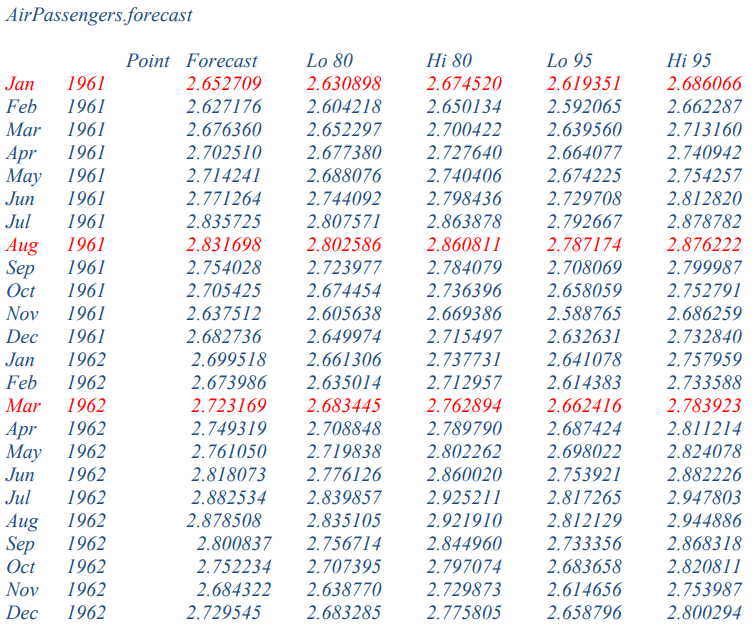

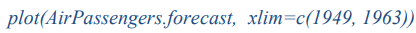
<br>
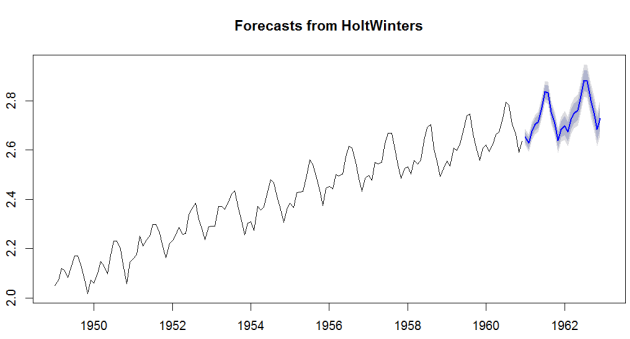
